In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica', 'Computer Modern Sans Serif']
import seaborn as sns
from itertools import combinations
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import defaultdict
from src.processing import null_association, MedianImputer, data_dict, CountEncoder, classifier_pipeline
from src.plotting import group_barplot, plot_classification_report

In [2]:
df = pd.read_csv("../data/Dataset.csv")

#### Feature engineering & data processing

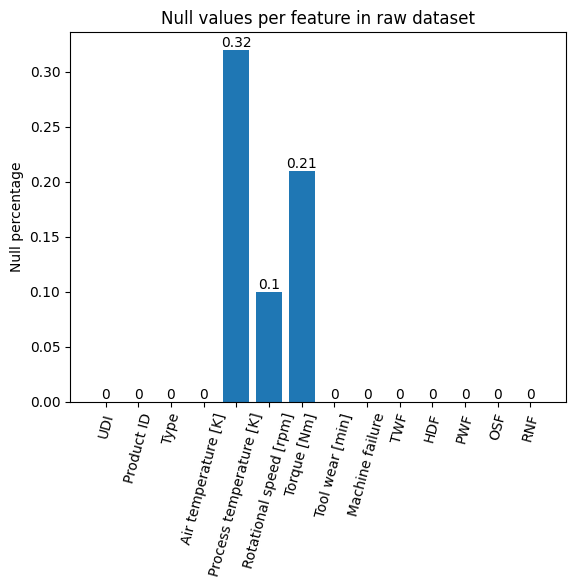

In [3]:
# Checking null values
null_vals = (df.isnull().sum()/df.shape[0])*100
_, ax = plt.subplots()
ax.bar(null_vals.index, null_vals.values)
ax.bar_label(ax.containers[0])
ax.set_ylabel("Null percentage")
ax.tick_params(axis="x", rotation=75)
ax.set_title("Null values per feature in raw dataset")
plt.show()

In [4]:
# Analysing null values between columns to understand the relationship between missing values
# in different cols, this would help determining the best imputation method to use.
# Since there is not a clear correlation between missing values, statistical imputation will be used.
# median value per type group will be used. The imputation will be carried out in the modelling section.
null_relationship = null_association(df)
null_relationship

,Process temperature [K],Rotational speed [rpm],Torque [Nm]
Process temperature [K],32,0,0
Rotational speed [rpm],0,10,0
Torque [Nm],0,0,21


In [5]:
# Introducing new features

df_cp = df.copy()
df_cp['Temp_diff'] = df_cp['Process temperature [K]'] - df_cp['Air temperature [K]']
df_cp['Power'] = df_cp['Torque [Nm]'] * df_cp['Rotational speed [rpm]']

In [6]:
unwanted_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
target_col = ['Machine failure']
num_cols = [col for col in df_cp.columns if df_cp[col].dtypes!="object" and col!="UDI" and col not in unwanted_cols+target_col]
obj_cols = [col for col in df_cp.columns if df_cp[col].dtypes=="object" and col!="Product ID"]

#### Data analysis

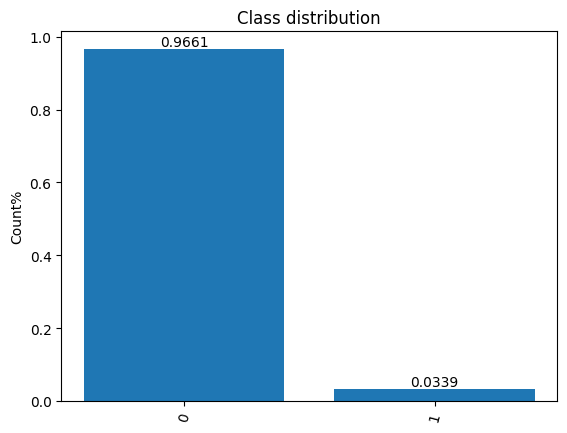

In [7]:
# Checking class balance
_, ax = plt.subplots()
ax.bar(df_cp["Machine failure"].value_counts().index, df_cp["Machine failure"].value_counts().values/df_cp.shape[0])
ax.bar_label(ax.containers[0])
ax.set_ylabel("Count%")
ax.tick_params(axis="x", rotation=75)
ax.set_title("Class distribution")
ax.set_xticks([0, 1])
plt.show()

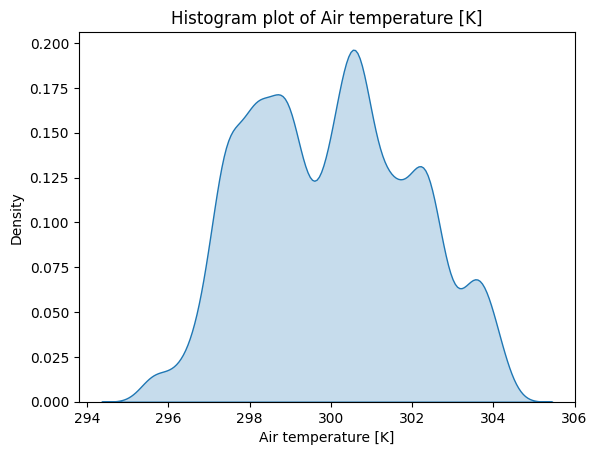

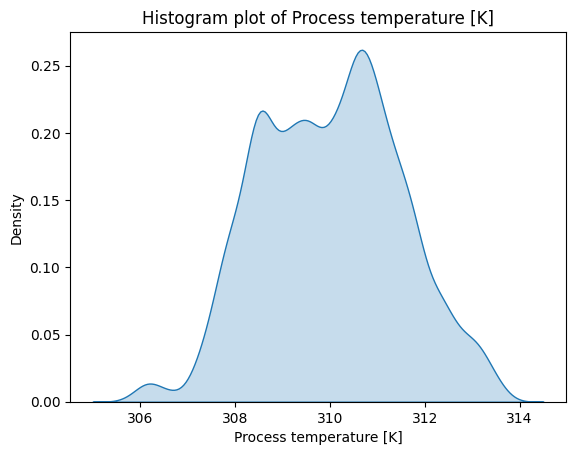

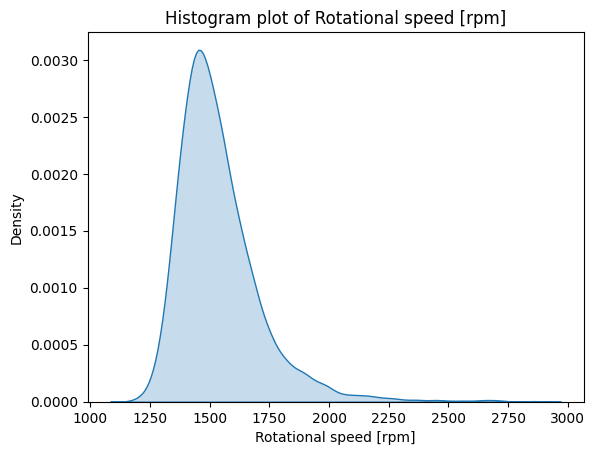

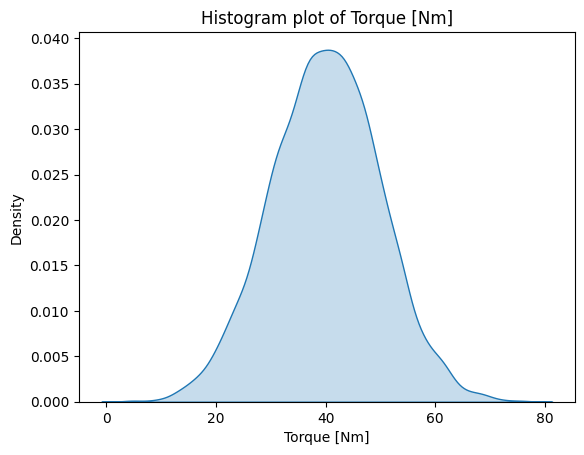

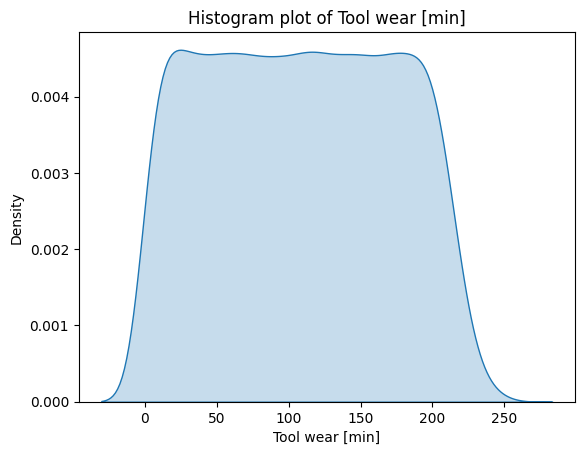

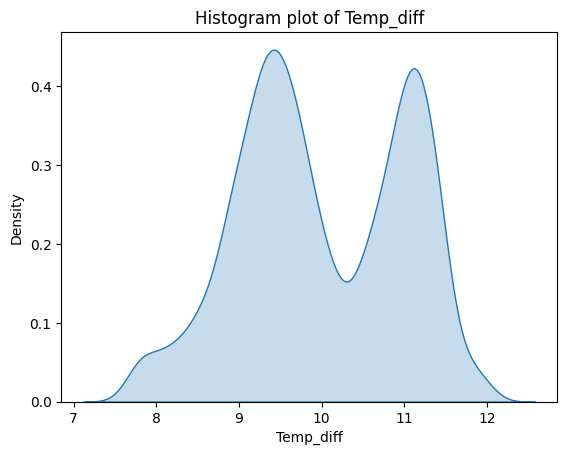

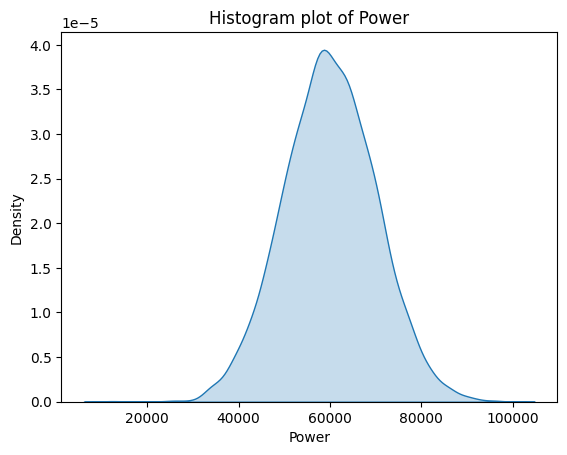

In [8]:
# feature analysis
for col in num_cols:
    _, ax = plt.subplots()
    sns.kdeplot(data=df_cp, x=col, fill=True)
    ax.set_title(f"Histogram plot of {col}")
    plt.show()


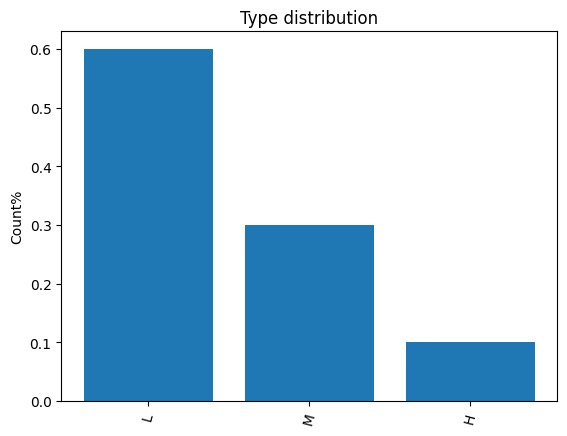

In [9]:
# Checking Type value distribution

_, ax = plt.subplots()
ax.bar(df_cp["Type"].value_counts().index, df_cp["Type"].value_counts().values/df_cp.shape[0])
ax.set_ylabel("Count%")
ax.tick_params(axis="x", rotation=75)
ax.set_title("Type distribution")
ax.set_xticks(["L", "M", "H"])
plt.show()

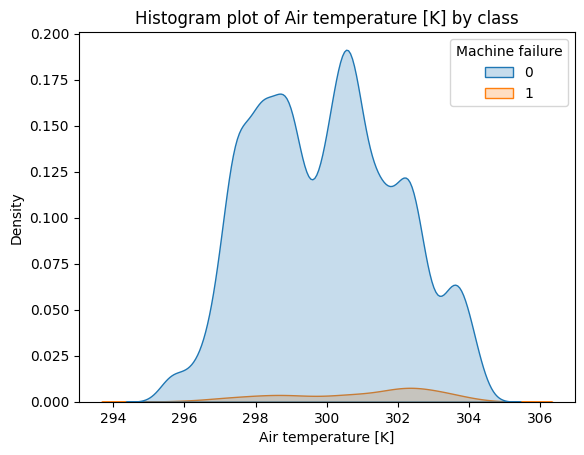

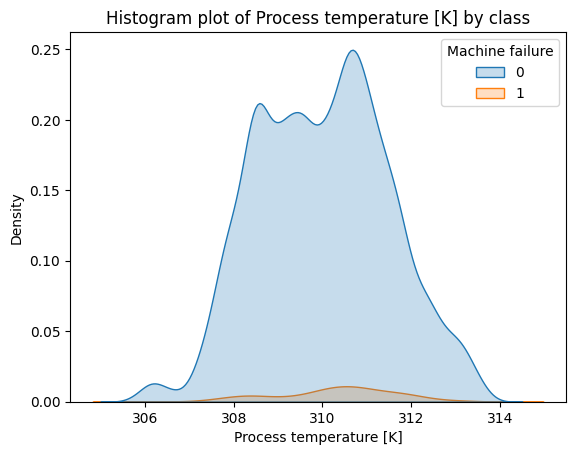

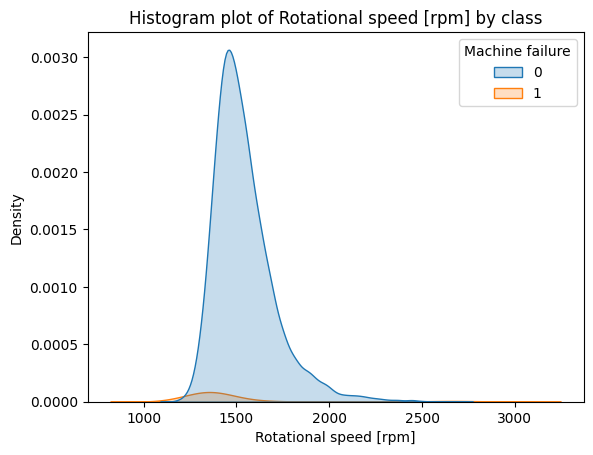

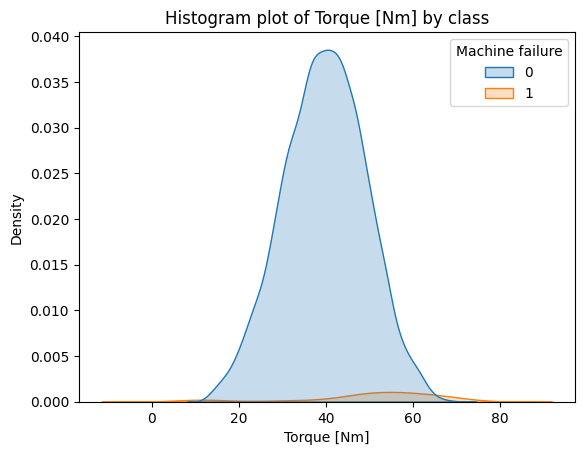

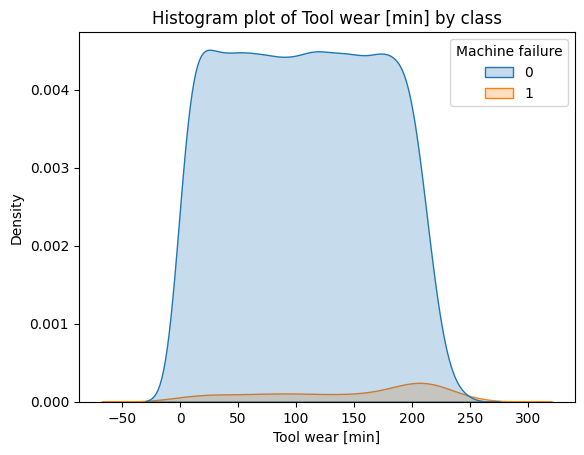

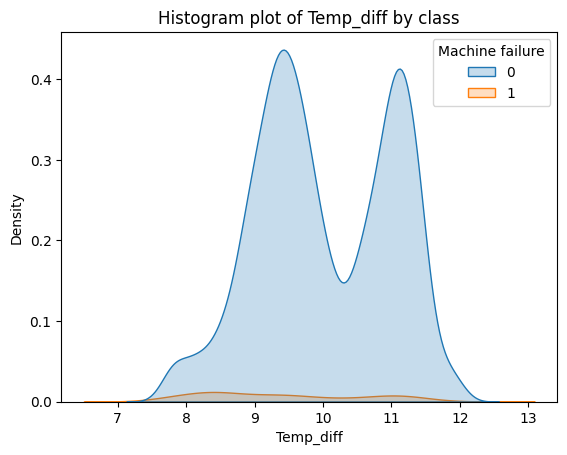

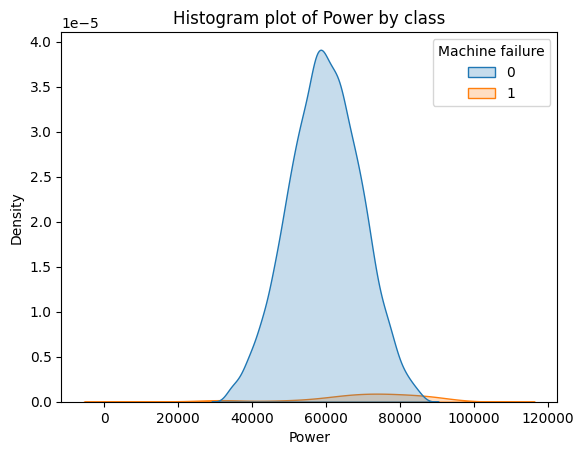

In [10]:
# feature analysis by class
for col in num_cols:
    _, ax = plt.subplots()
    sns.kdeplot(data=df_cp, x=col, hue="Machine failure", fill=True)
    ax.set_title(f"Histogram plot of {col} by class")
    plt.show()

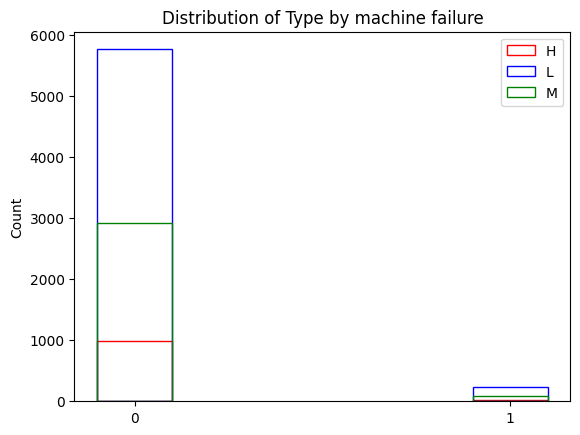

In [11]:
# Checking type distribution by class
column_dict = data_dict(df, "Type")
group_barplot(column_name="Type", data=column_dict)

In [12]:
# Assessing the relationship between features and target

df_full = df_cp.dropna()
features = df_full[num_cols]
target = df_full[target_col]

metric = mutual_info_classif(features, target)
metric_df = pd.Series(metric)
metric_df.index = num_cols
print(metric_df)

Air temperature [K]        0.005785
Process temperature [K]    0.000479
Rotational speed [rpm]     0.036984
Torque [Nm]                0.046091
Tool wear [min]            0.012467
Temp_diff                  0.010831
Power                      0.043245
dtype: float64


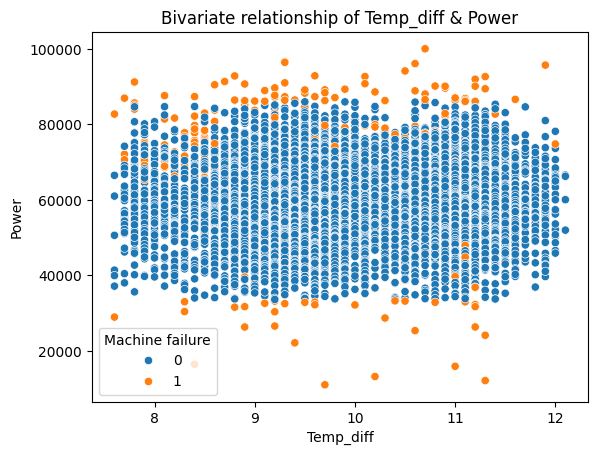

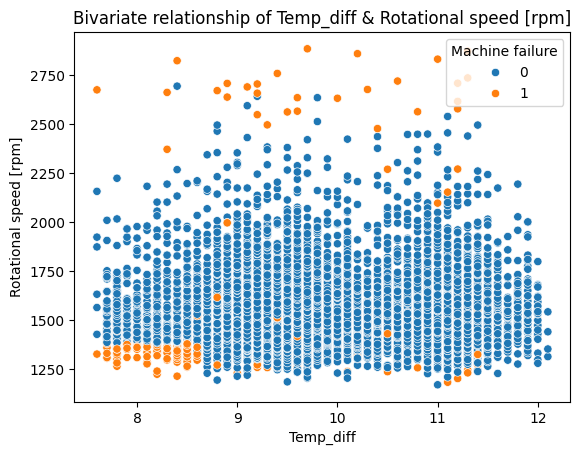

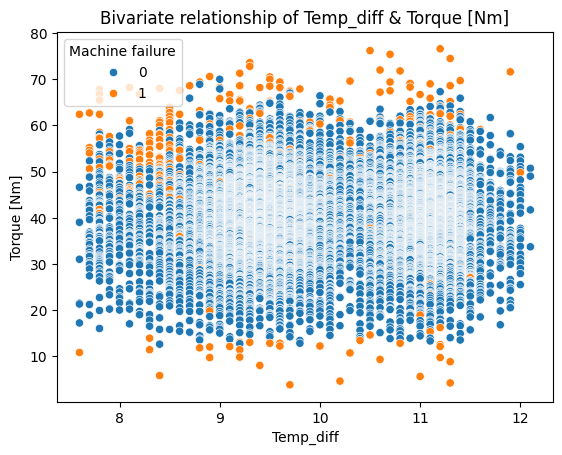

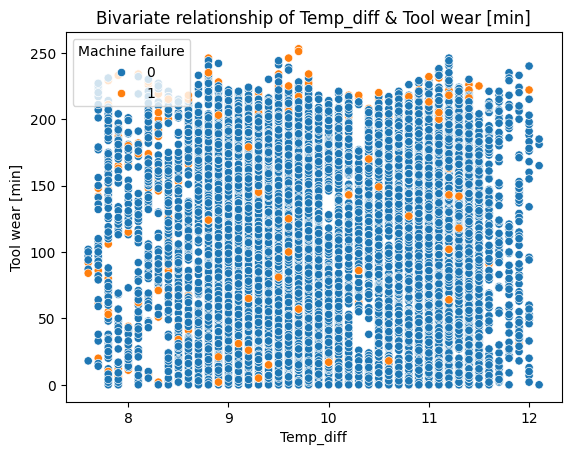

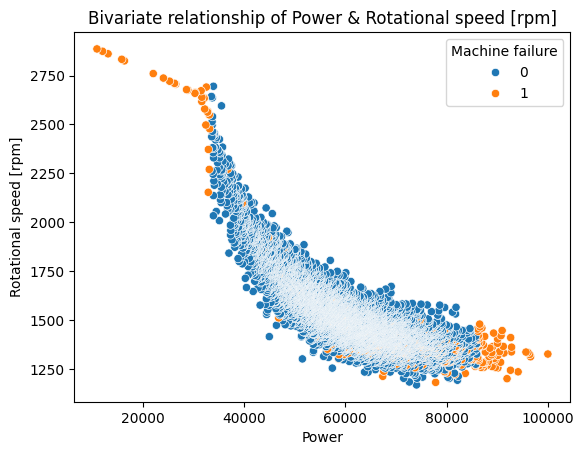

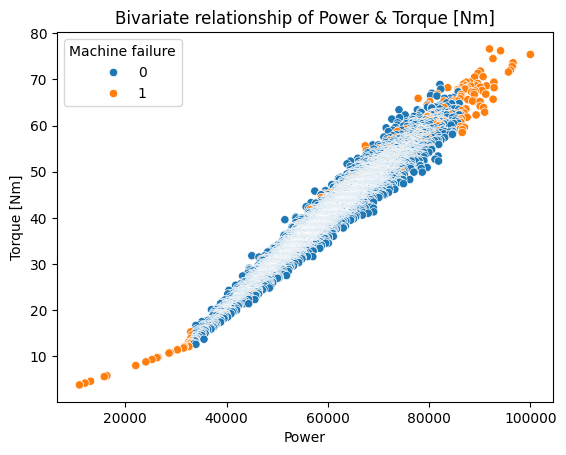

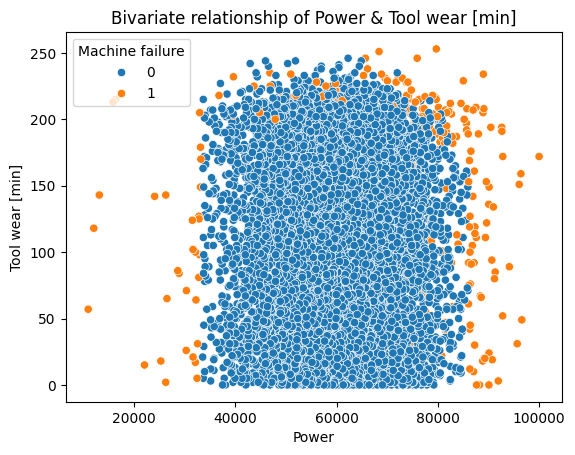

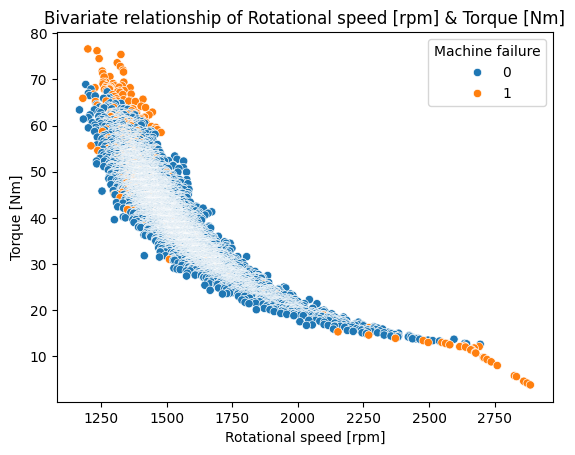

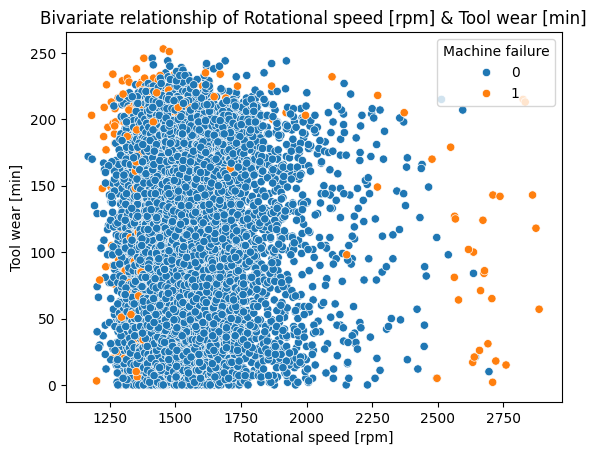

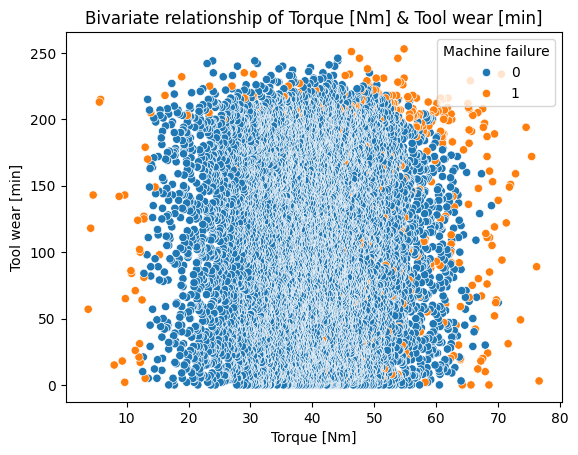

In [13]:
# Exploring bivariate relationship

selected_cols = ["Temp_diff", "Power", "Rotational speed [rpm]", 'Torque [Nm]', 'Tool wear [min]']
combs = combinations(selected_cols, 2)
for c1, c2 in combs:
    _, ax = plt.subplots()
    sns.scatterplot(data=df_cp, x=c1, y=c2, hue="Machine failure")
    ax.set_title(f"Bivariate relationship of {c1} & {c2}")
    plt.show

#### Modelling

In [ ]:
# Splitting data, imputing missing values & encoding categorical variables
# Instantiating, fitting model on training data and predicting on test data
RFClassifier = RandomForestClassifier(random_state=42)
y_test, predictions = classifier_pipeline(df=df_cp, target_col=target_col, num_cols=num_cols, cat_cols=obj_cols, model=RFClassifier)

In [15]:
# Evaluating predictions

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, output_dict=True)

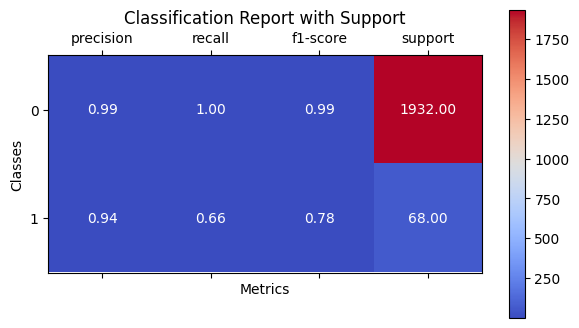

In [16]:
# Plotting confusion matrix
# Model is showing reasonable accuracy in detecting minority class.

plot_classification_report(report)

#### Exploring target variables

In [17]:
# Although it has fewer instances of positive cases, PWF, OSF, HDF are the best target in detecting positive machine failure cases
# This suggests that inadequate levels of power, stress and heating are good indicators of machine failure.
target_dict = defaultdict(list)
col_index = []
for t in unwanted_cols:
    RFClassifier = RandomForestClassifier(random_state=42)
    y_test, predictions = classifier_pipeline(df=df_cp, target_col=t, num_cols=num_cols, cat_cols=obj_cols, model=RFClassifier)
    report = classification_report(y_test, predictions, output_dict=True)
    col_index.append(t)
    target_dict["Precision_N_cls"].append(report["0"]["precision"])
    target_dict["recall_N_cls"].append(report["0"]["recall"])
    target_dict["precision_P_cls"].append(report["1"]["precision"])
    target_dict["recall_P_cls"].append(report["1"]["recall"])
df_target = pd.DataFrame(target_dict, index = col_index)

In [18]:
df_target

,Precision_N_cls,recall_N_cls,precision_P_cls,recall_P_cls
TWF,0.995500,1.000000,0.000000,0.0
HDF,1.000000,0.998988,0.920000,1.0
PWF,1.000000,0.998990,0.904762,1.0
OSF,0.997984,1.000000,1.000000,0.8
RNF,0.998000,1.000000,0.000000,0.0


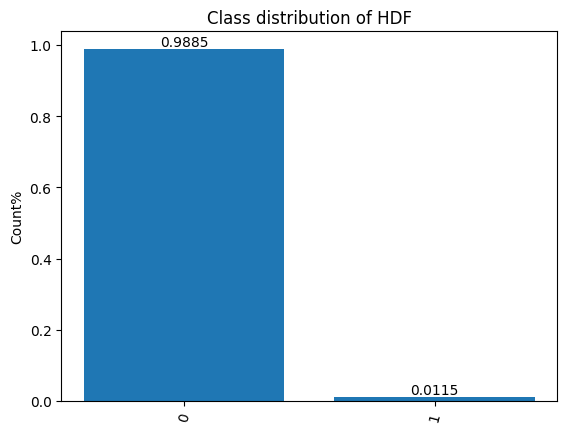

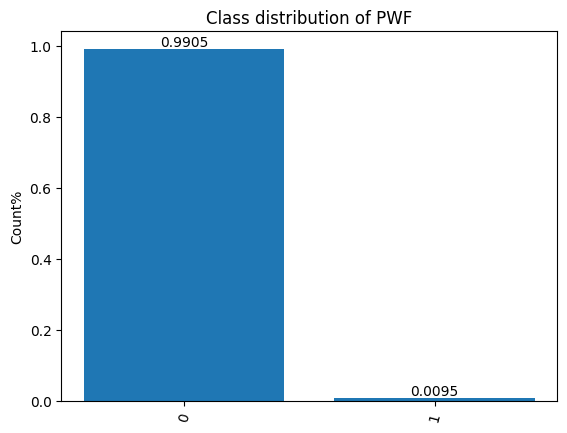

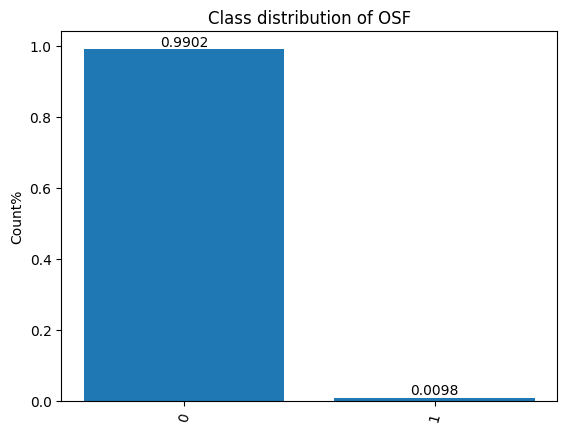

In [19]:
# Checking class balance
for t in ["HDF", "PWF", "OSF"]:
    _, ax = plt.subplots()
    ax.bar(df_cp[t].value_counts().index, df_cp[t].value_counts().values/df_cp.shape[0])
    ax.set_ylabel("Count%")
    ax.bar_label(ax.containers[0])
    ax.tick_params(axis="x", rotation=75)
    ax.set_title(f"Class distribution of {t}")
    ax.set_xticks([0, 1])
    plt.show()